In [1]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

np.set_printoptions(suppress=True)
%matplotlib inline

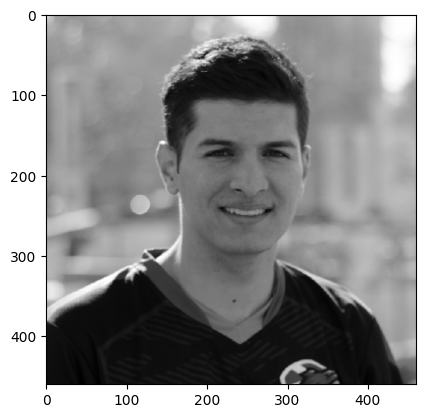

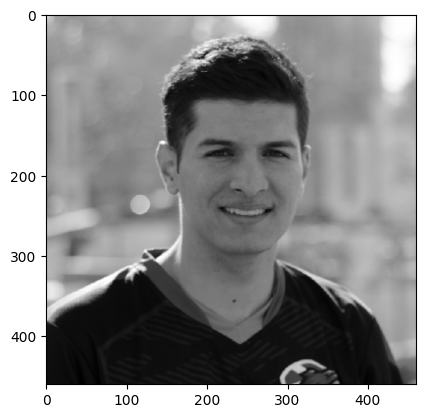

In [4]:
img1_f = 'sources/raoul.png'
img1 = cv2.cvtColor(cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)

img2_f = 'sources/raoul.png'
img2 = cv2.cvtColor(cv2.cvtColor(cv2.imread(img2_f), cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')

plt.figure()
plt.imshow(img2, cmap='gray')